In [1]:
from pathlib import Path
from datetime import datetime
from dateutil import tz

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation
from metpy.plots.ctables import registry
from metpy.plots import USCOUNTIES
from metpy.units import units
from siphon.catalog import TDSCatalog
import xarray as xr

In [10]:
# Scan the catalog and download the data
def get_satellite(frame):
    satcat = TDSCatalog('https://thredds.ucar.edu/thredds/catalog/satellite/goes/east/products/'
                        'CloudAndMoistureImagery/CONUS/Channel08/current/catalog.xml')
    dataset = satcat.datasets[frame]
    dataset = dataset.remote_access(use_xarray=True)
    return dataset

# Convert UTC time to Eastern Time
def convert_datetime(dt):
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('America/New York')
    utc_time = datetime.strptime(dt, '%Y-%m-%dT%H:%M:%S').replace(tzinfo=from_zone)
    eastern = utc_time.astimezone(to_zone)
    date_time = datetime.strftime(eastern, '%a, %b %d, %Y %I:%M %p').lstrip('0').replace(' 0', ' ')
    return date_time

In [11]:
# Store satellite time-series data in a tuple
datasets = ()

for frame in range(72, -1, -6):
    ds = get_satellite(frame)
    datasets = (*datasets, ds)

/Users/rhawthorne/miniconda3/envs/metpy/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  # This is added back by InteractiveShellApp.init_path()


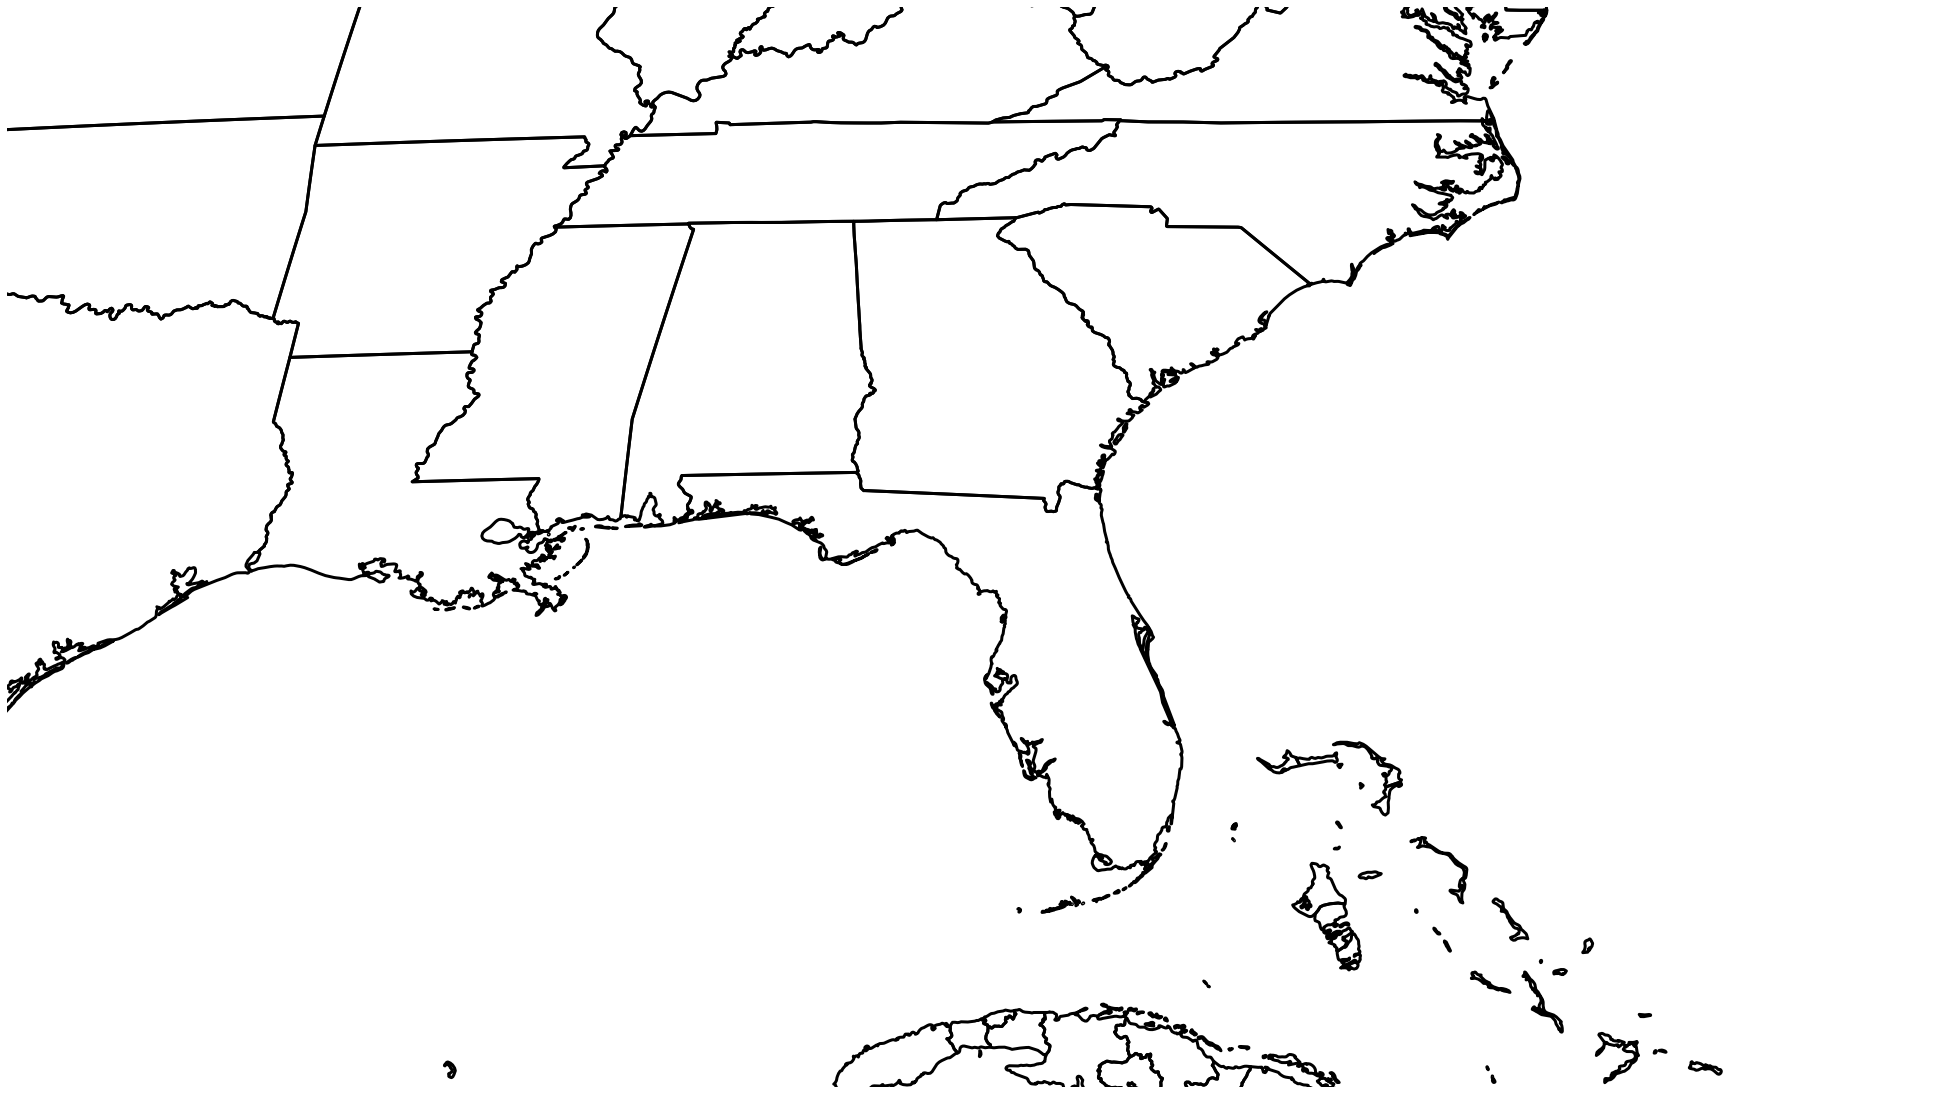

In [7]:
#%%capture
# Grab first dataset and make figure using its projection data
data = datasets[0].metpy.parse_cf('Sectorized_CMI')
proj = data.metpy.cartopy_crs

fig = plt.figure(figsize=(1920/72, 1080/72))
ax = fig.add_axes([0, 0, 1, 1], projection=proj)
ax.set_extent([-96.1, -70, 23.2, 37.5])
ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=3.0)
ax.set_adjustable('datalim')
ax.outline_patch.set_visible(False)

norm, cmap = registry.get_with_range('WVCIMSS_r', 200, 250)

In [8]:
# Container for the artists of all frames. Each item is a tuple of (image, text)
artists = []

for ds in datasets:
    data = ds.metpy.parse_cf('Sectorized_CMI')
    x = data['x']
    y = data['y']
    
    VALID_TIME = convert_datetime(str(data['time'].values).split('.')[0])
    timestamp = datetime.strptime(ds.start_date_time, '%Y%j%H%M%S')
    
    # Create Banner
    banner = ax.text(s=f'GOES-16 Upper-Level Water Vapor (~400-300 mb) \n{VALID_TIME}', y=0.95, x=0.01, 
                     transform=ax.transAxes, zorder=100, fontname='Arial', color='white',
                     fontweight='bold', fontsize=48, va='top',
                     bbox=dict(facecolor='navy', alpha=1.0, edgecolor='none'))
    
    # Plot the image
    im = ax.imshow(data, extent=(x.min(), x.max(), y.min(), y.max()),
                   origin='upper', cmap=cmap, norm=norm)
    
    artists.append((banner, im))


In [9]:
# Build and save animation
graphics_dir = Path('.') / '..' / '..' / 'graphics' / 'satellite'
anim = ArtistAnimation(fig, artists, interval=200., blit=False)
anim.save(f'{graphics_dir}/wv_upper.mp4', writer='ffmpeg')